## Load the most processed version of the data file

In [4]:
import time
import sys
import numpy as np
import pandas as pd

In [5]:
#takes about 40 secs to load
path = 'data/processed/LoanStats-combined-z-2.csv'
t1 = time.time()
df = pd.read_csv(path)
t2 = time.time()
print "{} bytes loaded in {:0.3f} secs".format(sys.getsizeof(df),t2-t1)
print df.shape


/Users/stephane/anaconda/lib/python2.7/site-packages/IPython/core/interactiveshell.py:2723: DtypeWarning: Columns (19,47,55) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


2095270415 bytes loaded in 25.011 secs
(887382, 150)


## Finally, create a list of features for fitting a model

As a first pass, I'm only pulling out numeric features. Text processing can be added later.

In [44]:
# I spent an unnecessary amount of time figuring out how to do this, and it turns out there's  a builtin for it...
working_feature_cols=list(df._get_numeric_data().columns) 
print "non-numeric cols:"
print set(df.columns) - set(working_feature_cols)
# remove cols we won't use for model fitting
skip_cols = [
    'lc_id', 'member_id', 'loan_status_num', 'grade_num',
    'collection_recovery_fee',
    'out_prncp',
    'out_prncp_inv',
    'pymnt_plan',
    'recoveries',
    'sub_grade',
    'total_pymnt',
    'total_pymnt_inv',
    'total_rec_int',
    'total_rec_late_fee',
    'total_rec_prncp',
    ]
zil_cols = ['zil_coef', 'zil_interc']
all_features = list(set(working_feature_cols)-set(skip_cols)-set(zil_cols))
all_featuresz = list(set(working_feature_cols)-set(skip_cols))
print "numeric feature cols ({}):".format(len(working_feature_cols))
print working_feature_cols

non-numeric cols:
set(['grade', 'application_type', 'emp_length', 'last_credit_pull_d', 'emp_title', 'verification_status_joint', 'title', 'initial_list_status', 'next_pymnt_d', 'earliest_cr_line', 'zip_code', 'verification_status', 'last_pymnt_d', 'sub_grade', 'pymnt_plan', 'purpose', 'addr_state', 'desc', 'term', 'url', 'revol_util', 'int_rate', 'loan_status', 'home_ownership', 'issue_d'])
numeric feature cols (125):
['lc_id', 'member_id', 'loan_amnt', 'funded_amnt', 'funded_amnt_inv', 'installment', 'annual_inc', 'dti', 'delinq_2yrs', 'inq_last_6mths', 'mths_since_last_delinq', 'mths_since_last_record', 'open_acc', 'pub_rec', 'revol_bal', 'total_acc', 'out_prncp', 'out_prncp_inv', 'total_pymnt', 'total_pymnt_inv', 'total_rec_prncp', 'total_rec_int', 'total_rec_late_fee', 'recoveries', 'collection_recovery_fee', 'last_pymnt_amnt', 'collections_12_mths_ex_med', 'mths_since_last_major_derog', 'policy_code', 'annual_inc_joint', 'dti_joint', 'acc_now_delinq', 'tot_coll_amt', 'tot_cur_bal

## After all that, finally ready to try to fit something?

In [45]:
%matplotlib inline
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.cross_validation import train_test_split
from sklearn import metrics


In [134]:
# 20000,33,2
parms_sample_size = 20000
random_state_resample = 33
random_state2_tts = 2

### Initially, downsample the DataFrame for quicker testing

This also filters out rows with no zillow zip code, and rows who's loan status is different from what we want

In [135]:
validindexlist=((df.loan_status_num == 1) | (df.loan_status_num == 0)) & (~np.isnan(df.zil_coef))
# use random_state = 33 for unbridled success!
minidf=df[validindexlist].sample(n=parms_sample_size,random_state=random_state_resample).fillna(0)
#validindexlist2=((df.loan_status_num == 1) | (df.loan_status_num == 0)) & (~np.isnan(df.zil_coef))
#minidf2=df[validindexlist2].sample(n=10000,random_state=33).fillna(0)
minidf.sort_values(by='grade_num',inplace=True)
print len(validindexlist)
print validindexlist.value_counts()
print minidf.shape

887382
True     604545
False    282837
dtype: int64
(20000, 150)


### Okay setup X and y for analysis:

In [136]:
#X = df[num_cols][validindexlist].fillna(0)
#X = pd.DataFrame(minidf['grade_num'][validindexlist].fillna(0)) # just grade num, like before
#X = pd.DataFrame(
#    df[(list(['grade_num'])+num_cols)[0:10]][validindexlist].fillna(0)) # new vals + grade_num
# X = pd.DataFrame(minidf[num_cols[0:10]][validindexlist].fillna(0)) # just a few new features
X = minidf[all_features]
Xz = minidf[all_featuresz]
y = minidf.loan_status_num
print type(X) ,X.shape
print type(Xz) ,Xz.shape
print type(y), y.shape
print np.isnan(y).value_counts()
print 'done'

<class 'pandas.core.frame.DataFrame'> (20000, 110)
<class 'pandas.core.frame.DataFrame'> (20000, 112)
<class 'pandas.core.series.Series'> (20000,)
False    20000
Name: loan_status_num, dtype: int64
done


## Maybe make a quick attempt to find best estimators

In [137]:
from sklearn.feature_selection import SelectKBest, f_regression
numfeaturestofind = 50

In [138]:
selector = SelectKBest(f_regression, k=numfeaturestofind).fit(X, y)
best_features = selector.get_support(indices=True)
print(best_features)
print X.columns[best_features]

[  2   4  10  11  12  18  19  20  22  23  25  27  29  30  31  33  36  40
  42  44  45  47  48  49  55  56  57  65  71  73  75  77  78  80  81  82
  83  84  85  87  88  89  90  91  92  94  95  97  98 100]
Index([u'inq_last_6mths', u'num_sats', u'mths_since_recent_bc', u'avg_cur_bal',
       u'total_bal_ex_mort', u'mths_since_last_major_derog', u'num_op_rev_tl',
       u'num_actv_rev_tl', u'mo_sin_old_il_acct', u'num_rev_accts',
       u'verification_status_Verified', u'max_bal_bc', u'num_bc_tl',
       u'open_il_24m', u'pct_tl_nvr_dlq', u'total_rev_hi_lim',
       u'total_bc_limit', u'term_num', u'open_rv_12m', u'all_util',
       u'mo_sin_rcnt_rev_tl_op', u'mths_since_recent_inq', u'tot_hi_cred_lim',
       u'open_rv_24m', u'annual_inc', u'last_pymnt_amnt', u'num_il_tl',
       u'num_bc_sats', u'mths_since_recent_revol_delinq',
       u'total_il_high_credit_limit', u'inq_last_12m', u'mo_sin_rcnt_tl',
       u'purpose_small_business', u'tot_cur_bal', u'num_rev_tl_bal_gt_0',
       u'hom

In [139]:
selector = SelectKBest(f_regression, k=numfeaturestofind).fit(Xz, y)
best_featuresz = selector.get_support(indices=True)
print(best_featuresz)
print Xz.columns[best_featuresz]

[  2   4  10  11  12  16  19  20  21  23  24  26  28  29  31  32  33  34
  38  42  44  47  49  50  51  57  58  59  65  67  73  74  75  79  80  82
  83  84  86  87  89  90  91  92  93  94  96  98  99 101]
Index([u'inq_last_6mths', u'num_sats', u'mths_since_recent_bc', u'avg_cur_bal',
       u'total_bal_ex_mort', u'open_il_6m', u'mths_since_last_major_derog',
       u'num_op_rev_tl', u'num_actv_rev_tl', u'mo_sin_old_il_acct',
       u'num_rev_accts', u'verification_status_Verified', u'max_bal_bc',
       u'total_bal_il', u'num_bc_tl', u'open_il_24m', u'pct_tl_nvr_dlq',
       u'purpose_small_business', u'total_bc_limit', u'term_num',
       u'open_rv_12m', u'mo_sin_rcnt_rev_tl_op', u'mths_since_recent_inq',
       u'tot_hi_cred_lim', u'open_rv_24m', u'annual_inc', u'last_pymnt_amnt',
       u'num_il_tl', u'all_util', u'num_bc_sats',
       u'mths_since_recent_revol_delinq', u'total_acc',
       u'total_il_high_credit_limit', u'mo_sin_rcnt_tl', u'total_rev_hi_lim',
       u'tot_cur_bal', 

In [140]:
print set(X.columns[best_features]) - set(Xz.columns[best_featuresz])
print set(Xz.columns[best_featuresz]) - set(X.columns[best_features])


set([])
set([])


## To begin, use GridSearchCV to  Fit a bunch of logregs & find best estimator



In [141]:
from sklearn.cross_validation import cross_val_score
from sklearn.grid_search import GridSearchCV
from sklearn.cross_validation import train_test_split
from operator import itemgetter

#scores = cross_val_score(logreg, X, y, cv=10, scoring='accuracy')
# from 
# http://scikit-learn.org/stable/auto_examples/model_selection/randomized_search.html
# example-model-selection-randomized-search-py
# Utility function to report best scores
def report(grid_scores, n_top=3):
    top_scores = sorted(grid_scores, key=itemgetter(1), reverse=True)[:n_top]
    for i, score in enumerate(top_scores):
        print("Model with rank: {0}".format(i + 1))
        print("Mean validation score: {0:.3f} (std: {1:.3f})".format(
              score.mean_validation_score,
              np.std(score.cv_validation_scores)))
        print("Parameters: {0}".format(score.parameters))
        print("")

In [142]:
# random_state = 2 was pretty good
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=random_state2_tts)
Xz_train, Xz_test, yz_train, yz_test = train_test_split(Xz, y, random_state=random_state2_tts)
print all(y_train == yz_train)
print all(yz_test == y_test)

True
True


### Here's the meat, takes a little longer to run:

In [143]:
logreg = LogisticRegression()
logregz = LogisticRegression()
param_grid = {'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000] }

# run grid search
grid_search = GridSearchCV(logreg, param_grid=param_grid)
grid_searchz = GridSearchCV(logregz, param_grid=param_grid)
start = time.time()
grid_search.fit(X_train, y_train)
grid_searchz.fit(Xz_train, yz_train)

print("GridSearchCV took %.2f seconds for %d candidate parameter settings."
      % (time.time() - start, len(grid_search.grid_scores_)))
print "Without Zillow:"
report(grid_search.grid_scores_,n_top=1)
print "With Zillow:"
report(grid_searchz.grid_scores_,n_top=1)
logreg = grid_search.best_estimator_
logregz = grid_searchz.best_estimator_


GridSearchCV took 69.03 seconds for 7 candidate parameter settings.
Without Zillow:
Model with rank: 1
Mean validation score: 0.936 (std: 0.000)
Parameters: {'C': 0.1}

With Zillow:
Model with rank: 1
Mean validation score: 0.937 (std: 0.000)
Parameters: {'C': 1}



## Okay, how did the model do?

In [113]:
from sklearn.cross_validation import cross_val_predict
#y_pred_class = cross_val_predict(logreg, X, y, cv=10)
y_pred_class = grid_search.predict(X_test)
yz_pred_class = grid_searchz.predict(Xz_test)
y_pred_prob = grid_search.predict_proba(X_test)[:,1]
yz_pred_prob = grid_searchz.predict_proba(Xz_test)[:,1]


In [114]:
#y_test = y
print "percent of loans successful in y_test: {}/{} = {}".format(
    y_test[y_test == 1].count(), y_test.count(),
    float(y_test[y_test == 1].count())/ y_test.count() )
print metrics.accuracy_score(y_test,y_pred_class)

percent of loans successful in y_test: 4688/5000 = 0.9376
0.9372


In [144]:
print "percent of loans successful in y_test: {}/{} = {}".format(
    y_test[y_test == 1].count(), y_test.count(),
    float(y_test[y_test == 1].count())/ y_test.count() )
print "percent of loans predicted to be successful: {}/{} = {}".format(
    y_pred_class.sum() , len(y_pred_class),
    float(y_pred_class.sum())/len(y_pred_class))
                                                                 
print "percent of loans predicted to be successful with zillow: {}/{} = {}".format(
    yz_pred_class.sum() , len(yz_pred_class),
    float(yz_pred_class.sum())/len(yz_pred_class))
                                                                 
a = [i for i,x in enumerate(y_pred_class) if x != 1] # false predictions
print len(a), a
az = [i for i,x in enumerate(yz_pred_class) if x != 1] # false predictions
print len(az), az
#print y.iloc[a]
#print logreg2.classes_
#print y_pred_prob[a]
#print y_pred_prob[0:3]

print 'done'

percent of loans successful in y_test: 4688/5000 = 0.9376
percent of loans predicted to be successful: 4998.0/5000 = 0.9996
percent of loans predicted to be successful with zillow: 4997.0/5000 = 0.9994
2 [2342, 4735]
3 [2048, 2342, 4735]
done


### (this will be a good spot for a confusion matrix)

In [145]:
# save confusion matrix and slice into four pieces
confusion = metrics.confusion_matrix(y_test, y_pred_class)
confusionz = metrics.confusion_matrix(yz_test, yz_pred_class)
print confusion
print confusionz
TP = confusion[1][1]
TN = confusion[0][0]
FP = confusion[0][1]
FN = confusion[1][0]
print 'True Positives:', TP
print 'True Negatives:', TN
print 'False Positives:', FP
print 'False Negatives:', FN
# calculate the sensitivity
print "Sensitivity: {}%".format(TP / float(TP + FN))
#print "Sensitivity(z): {}%".format(confusionz[1][1]/float(confusionz[1][1]+confusionz[1][0]))
print "Sensitivity(z): {}%".format(confusionz[1][1]/float(confusionz[1].sum()))
# calculate the specificity
print "Specificity: {}%".format(TN / float(TN + FP))
print "Specificity(z): {}%".format(confusionz[0][0] / float(confusionz[0][0] + confusionz[0][1]))


[[   0  312]
 [   2 4686]]
[[   0  312]
 [   3 4685]]
True Positives: 4686
True Negatives: 0
False Positives: 312
False Negatives: 2
Sensitivity: 0.99957337884%
Sensitivity(z): 0.999360068259%
Specificity: 0.0%
Specificity(z): 0.0%


array([<matplotlib.axes._subplots.AxesSubplot object at 0x121b05dd0>,
       <matplotlib.axes._subplots.AxesSubplot object at 0x11f4e6e50>], dtype=object)

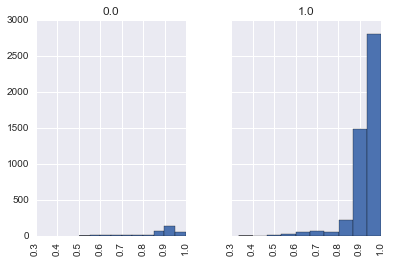

In [122]:
tempdf = pd.DataFrame({'probability':y_pred_prob, 'actual':y_test})
tempdf.hist(column='probability', by='actual', sharex=True, sharey=True)

0.732655525291
0.892924063396


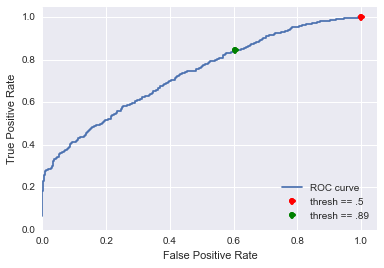

In [146]:
# ROC curve 
fpr, tpr, thresholds = metrics.roc_curve(y_test, y_pred_prob)
plt.plot(fpr, tpr,label = "ROC curve")
thresh_i = np.where(thresholds>.5)[0][-1]
plt.plot(fpr[thresh_i],tpr[thresh_i],'ro',label = 'thresh == .5')
thresh2 = np.where(fpr>.6)[0][0]
plt.plot(fpr[thresh2],tpr[thresh2],'go',label = 'thresh == .89')
plt.xlim([0,1.05])
plt.ylim([0,1.05])
plt.legend(loc="lower right")
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
print metrics.roc_auc_score(y_test, y_pred_prob)
print thresholds[fpr>.6][0]

In [ ]:
print type(tpr)
plt.plot(thresholds,tpr)
print thresholds[0:10]
print tpr[np.where(thresholds>.5)[0][-1]]
print tpr[thresholds>.5][-1]

### To check results of the fit, plot the predicted probabilities

This was a first attempt to view a correlation between the predicted probabilities and the outcomes of the loans. I hoped to see more 'defaults' (black points) toward the left, at the lower probabilities. However this graph didn't work very well.

In [ ]:
sis = y_pred_prob.argsort()
colormap = np.array(['r', 'k'])
plt.figure(figsize=(16, 3))
plt.scatter(range(len(y_pred_prob)),y_pred_prob[sis],color=colormap[list(y_test.iloc[sis])])
plt.xlim([0,len(y_test)])
#plt.scatter(range(len(y_test)),y_test.iloc[sis],color=colormap[list(y_test.iloc[sis])])
print type(y_test)

print len(y_test),len(sis)
print max(y_test),min(y_test)
print y_test.shape,sis.shape,len(y_test[sis]),y_test[sis].shape

### Second attempt to evaluate the model graphically

This graph shows a boxplot of predicted probabilities broken down into 2 groups based on outcome. It is clear that 'successful' loans (loan_status_num ==1) have a higher distribution of predicted probabilites than 'unsuccessful' loans (loan_status_num == 0).

In [ ]:
# merge these things into a single dataframe for plotting:
testdf=pd.concat([X_test,y_test,pd.DataFrame(y_pred_prob,columns=['y_pred_prob'])],axis=1)
testdf.boxplot(column='y_pred_prob',by='loan_status_num')
print testdf.loan_status_num.value_counts()

In [ ]:
grouped = testdf.groupby('loan_status_num')
grouped.y_pred_prob.quantile([.25, .5, .75, 1])


In [ ]:
#plt.scatter(df.grade_num,df.loan_status_num,label='loan status')
#plt.plot(df2.grade_num,df2.loan_status_pred_num,color='red')
#plt.plot(X_test['grade_num'].sort_values(),y_pred_class,color='red')
#plt.setp(plt.gca(), xticklabels=gradenames, xticks = gradenums)
#plt.setp(plt.gca(), yticklabels=np.arange(0,1.2,.2), yticks = np.arange(0,1.2,.2))
#plt.setp(plt.gca(),title = 'Predicted loan status, test set')

## next...

In [ ]:
print 'done'

In [ ]:
#print total_success_rate
print "percent of loans successful in y_test: {}/{} = {}".format(y_test[y_test == 1].count(), y_test.count(),
                                                       float(y_test[y_test == 1].count())/ y_test.count() )
print "logreg class prediction accuracy:" , metrics.accuracy_score(y_test, y_pred_class)
print "guess all successful accuracy: ", metrics.accuracy_score(y_test,[1]*len(y_test))

In [ ]:
grouped=minidf.groupby('grade')
probs=grouped.loan_status_num.sum()/grouped.loan_status_num.count()
print probs

In [ ]:
fig,ax = plt.subplots()
width=.4
xlocs=np.arange(0,7)
ax.bar(xlocs-width,grouped.loan_status_num.sum(),width,color='k')
ax.set_xticks(xlocs)
ax.set_xticklabels(sorted(minidf.grade.unique()))
ax.bar(
        xlocs,grouped.loan_status_num.apply(lambda item: (item == 0).sum()),width,
        color='r')
ax.set_title('Loan status by grade')

In [ ]:
#df2['loan_status_pred_prob']=logreg.predict_proba(X)[:,1]
plt.scatter(minidf.grade_num,minidf.loan_status_num)

In [ ]:
#plt.plot(minidf.grade_num,minidf.loan_status_pred_prob,color='red')
X_test_s=minidf.sort_values(by='grade_num').grade_num.reshape(-1,1)
plt.plot(X_test_s,logreg.predict_proba(X_test_s)[:,1],color='red')

plt.plot(probs,'go-')